In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **GEREKLİ KÜTÜPHANELERİN YÜKLENMESİ**



**Bu adımda derin öğrenme projesinde kullanılacak temel kütüphaneler yüklenmektedir. Veri işleme, görselleştirme ve model oluşturma gibi süreçlerde gerekli olan bu kütüphaneler, projenin sorunsuz çalışabilmesi için ortamda hazır hale getirilir.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from tensorflow.keras import layers , models
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import time
import warnings
warnings.filterwarnings('ignore')

2025-09-25 08:22:28.412361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758788548.631189      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758788548.694065      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Fashion MNIST Veri Setinin Yüklenmesi ve Eğitim-Test Ayrımı**

**Bu kod parçası, TensorFlow’un hazır olarak sunduğu Fashion MNIST veri setini kullanıma alır. İlk satırda fashion_mnist değişkenine bu veri seti atanır. Ardından load_data() fonksiyonu çağrılarak veri seti ikiye ayrılır: eğitim ve test verileri. Eğitim verileri training_images (görüntüler) ve training_labels (etiketler) şeklinde; test verileri ise testing_images ve testing_labels değişkenlerinde saklanır. Bu sayede model, eğitim aşamasında kıyafet görselleri üzerinden öğrenir, test aşamasında ise ayrı bir veri ile doğruluk kontrolü yapılır.**

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(training_images , training_labels) , (testing_images , testing_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Fashion MNIST Veri Setinin İncelenmesi ve Görselleştirilmesi**

**Bu kod parçası, Fashion MNIST veri setindeki görüntüleri ve etiketleri hem inceler hem de görselleştirir. İlk olarak np.squeeze fonksiyonu ile eğitim (training_labels) ve test (testing_labels) etiketleri tek boyutlu hale getirilir; bu sayede grafiklerde ve işlemlerde daha rahat kullanılabilir. Ardından, eğitim ve test görüntülerinin boyutları (shape) ekrana yazdırılır ve veri setinde toplam kaç sınıf bulunduğu öğrenilir. Bu sınıflara karşılık gelen kıyafet türleri class_names listesinde tanımlanır (örneğin tişört, pantolon, elbise, ayakkabı gibi). Daha sonra görselleştirme aşamasına geçilir: İlk olarak matplotlib ile 16 farklı eğitim görüntüsü 4x4 lük bir ızgara düzeninde gösterilir. Görsellerin kenar çizgileri, eksen değerleri kaldırılarak sade bir görünüm sağlanır ve her bir görselin üstüne ilgili sınıf ismi başlık olarak eklenir. İkinci görselleştirmede ise seaborn kütüphanesi kullanılarak hem eğitim hem de test verilerinin sınıf dağılımları sütun grafikleriyle çizdirilir. Bu grafikler sayesinde hangi sınıfın kaç adet örneğe sahip olduğu kolayca görülebilir. Genel olarak bu kod, veri setini anlamak, verilerin dengeli olup olmadığını analiz etmek ve görselleri inceleyerek model eğitimi öncesinde fikir edinmek için kullanılır.**

Training data format: (60000, 28, 28)
Test data format: (10000, 28, 28)
Number of classes: 10


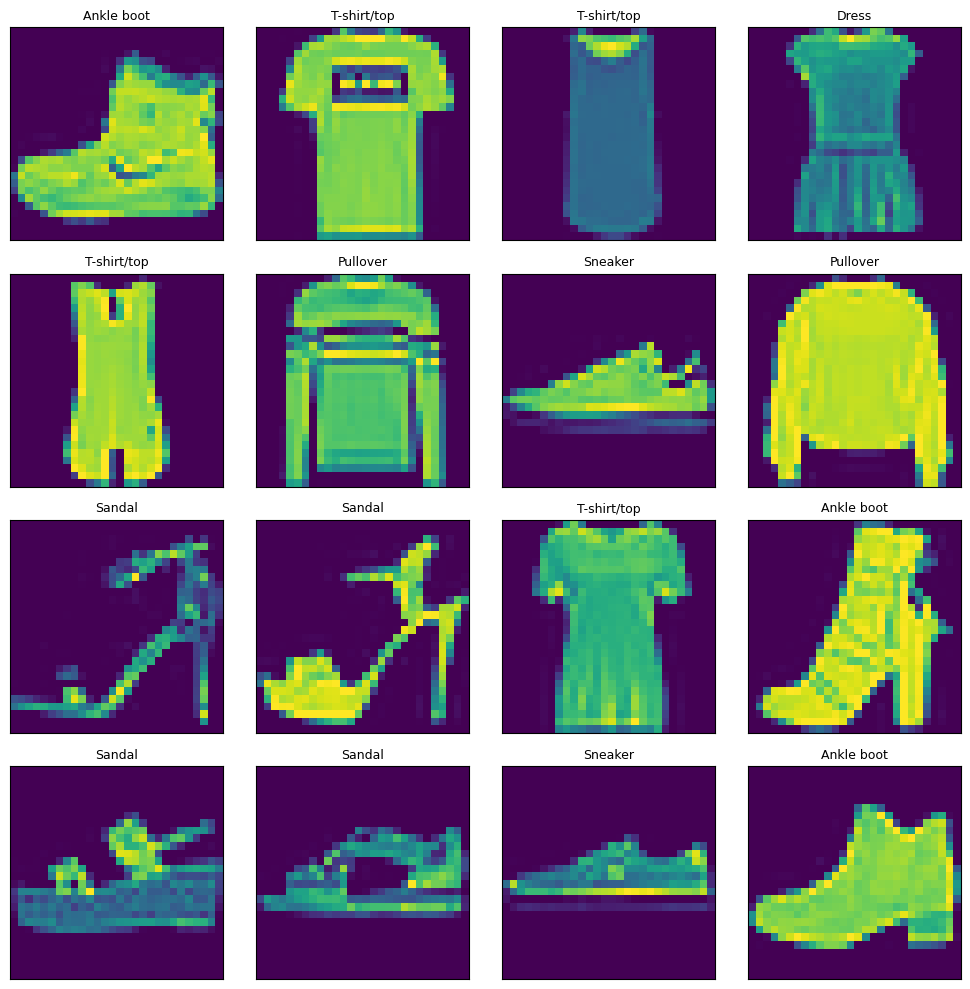

Text(0.5, 1.0, 'Class distribution in training set')

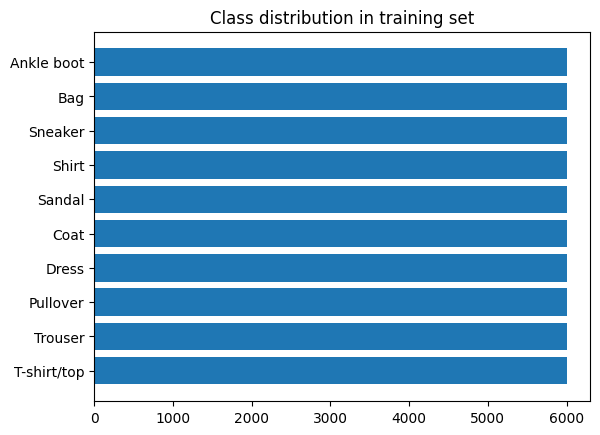

In [4]:
train_labels = np.squeeze(training_labels)
test_labels  = np.squeeze(testing_labels)


print("Training data format:", training_images.shape)
print("Test data format:", testing_images.shape)
print("Number of classes:", len(np.unique(training_labels)))


class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i])
    plt.title(class_names[int(training_labels[i])], fontsize=9)
plt.tight_layout()
plt.show()



classes, counts = np.unique(training_labels, return_counts=True)
plt.barh(class_names, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

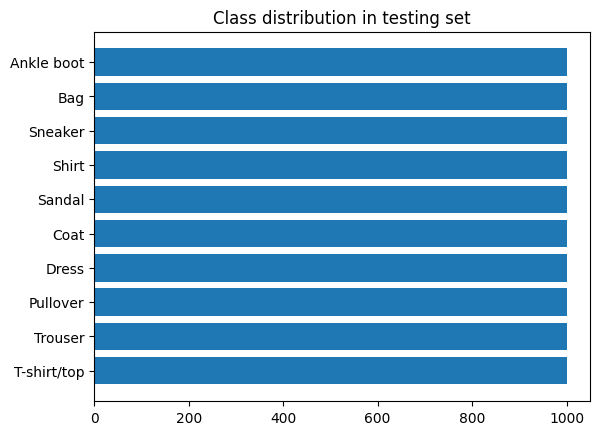

In [5]:
classes, counts = np.unique(testing_labels, return_counts=True)
plt.barh(class_names, counts)
plt.title('Class distribution in testing set')

# **Etiketlerin One-Hot Encoding Formatına Dönüştürülmesi**

Bu kod parçası, Fashion MNIST veri setindeki etiketleri (sınıf numaralarını) one-hot encoding denilen formata dönüştürmek için kullanılır. Normalde etiketler 0 ile 9 arasındaki sayılar şeklindedir (örneğin 0 = T-shirt/top, 1 = Trouser vb.). keras.utils.to_categorical fonksiyonu sayesinde bu sayısal değerler, 10 sınıfa karşılık gelen vektörlere dönüştürülür. Örneğin “2” etiketi [0,0,1,0,0,0,0,0,0,0] şeklinde temsil edilir. Böylece model, her bir görüntünün hangi sınıfa ait olduğunu daha net öğrenebilir. Eğitim etiketleri training_categorical, test etiketleri ise testing_categorical isimli değişkenlerde saklanır.

In [6]:
training_categorical = keras.utils.to_categorical(training_labels, 10)
testing_categorical = keras.utils.to_categorical(testing_labels, 10)

# **CNN Modelinin Oluşturulması ve Yapısının Görselleştirilmesi**

Bu kod parçası, Fashion MNIST verilerini sınıflandırmak için bir CNN (Convolutional Neural Network – Evrişimsel Sinir Ağı) modeli oluşturur. create_cnn_model() fonksiyonu tanımlanarak modelin katmanları sırasıyla eklenir. İlk bölümde 32 filtreli Conv2D katmanları ve BatchNormalization uygulanarak giriş görüntülerinden öznitelikler çıkarılır. Ardından MaxPooling2D katmanı ile boyut küçültülür. Sonraki blokta ise 64 filtreli iki adet evrişim katmanı ve normalizasyon katmanları bulunur; yine bir havuzlama katmanı ile boyut azaltılır. Evrişimsel katmanlardan sonra ağ düzleştirilir (Flatten) ve yoğun bağlantılı (Dense) katmanlara aktarılır. Burada 128 nöronlu, ReLU aktivasyonlu gizli katman bulunur, son katmanda ise 10 sınıf için softmax aktivasyonu kullanılır. Böylece model, her görüntünün hangi kıyafet sınıfına ait olduğunu olasılık dağılımı şeklinde tahmin eder. Kodun sonunda model çağrılır ve keras.utils.plot_model fonksiyonu ile modelin yapısı, katmanlar ve veri şekilleri görselleştirilir.

I0000 00:00:1758788564.590553      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758788564.591250      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


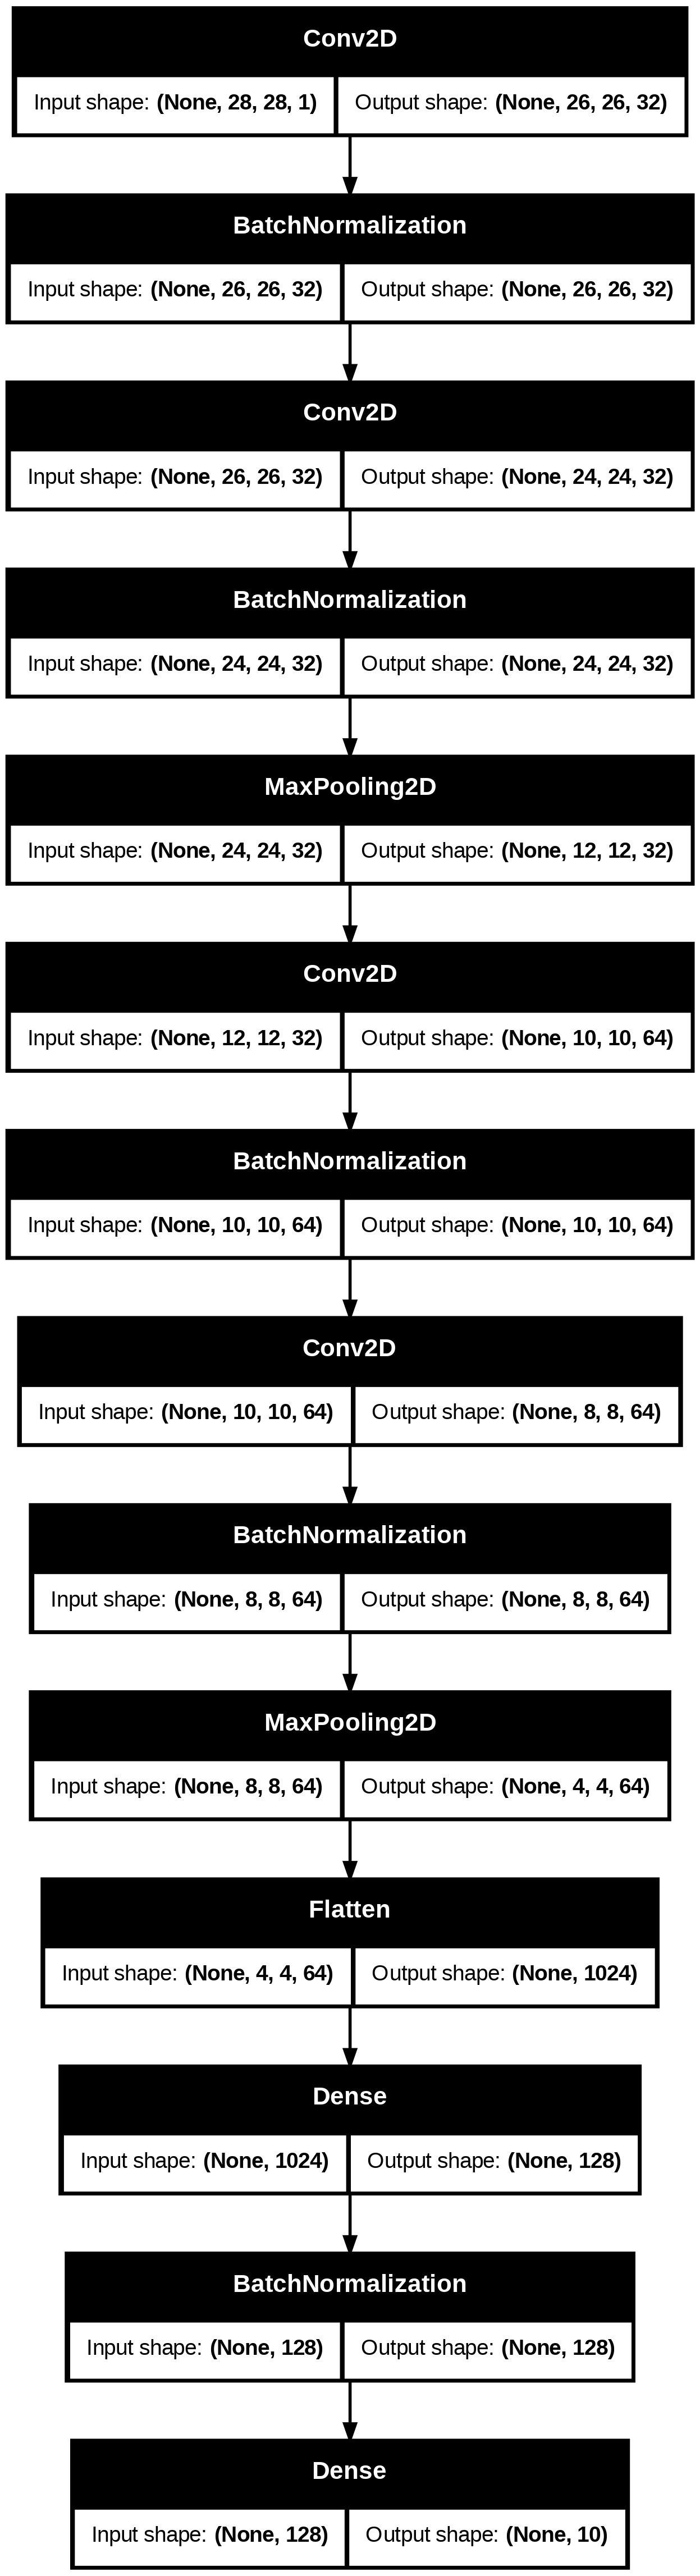

In [7]:
def create_cnn_model():
    model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
    ])     
    return model

cnn_model = create_cnn_model()

keras.utils.plot_model(cnn_model, show_shapes=True)

# **Veri Ön İşleme ve Data Augmentation Uygulamaları**

Bu kod parçası, modelin eğitimine uygun hale getirilmesi ve çeşitlendirilmesi amacıyla veri ön işleme ve veri artırma (Data Augmentation) işlemleri yapar. İlk olarak eğitim (training_images) ve test (testing_images) görüntüleri, evrişimsel sinir ağının girişine uygun formatta yeniden şekillendirilir. Görsellerin her biri 28x28 boyutunda olup, gri tonlamalı (tek kanal) olduğundan (28,28,1) şeklinde düzenlenir. Ardından ImageDataGenerator sınıfı kullanılarak eğitim verileri üzerinde çeşitli dönüşümler tanımlanır. Bu dönüşümler arasında rastgele açısal döndürme (rotation_range=15), yatay ve dikey kaydırmalar (width_shift_range, height_shift_range), yatay çevirme (horizontal_flip=True) ve yakınlaştırma (zoom_range=0.1) bulunur. Bu sayede model, aynı görüntünün farklı varyasyonlarını görerek daha genelleştirilebilir ve hatalara karşı dayanıklı hale gelir. Son olarak datagen.fit(training_images) ifadesiyle bu dönüşümler eğitim verisine uygulanmak üzere hazırlanır.

In [8]:
training_images = training_images.reshape(training_images.shape[0], 28, 28, 1)
testing_images = testing_images.reshape(testing_images.shape[0], 28, 28, 1)

datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(training_images)

# **Modelin Derlenmesi, Callback’lerin Tanımlanması ve Eğitim Sürecinin Gerçekleştirilmesi**

Bu kod parçası, CNN modelinin eğitim sürecini başlatmak ve daha verimli hale getirmek için hazırlanmıştır. İlk olarak eğitim ve test görüntüleri float32 tipine dönüştürülüp 0-1 aralığında normalize edilir, böylece modelin öğrenme süreci hızlanır ve kararlılık artar. Ardından model compile edilerek Adam optimizasyon algoritması, categorical crossentropy kayıp fonksiyonu ve accuracy metriği belirlenir. Eğitim sırasında performansı kontrol etmek için iki önemli geri çağırım (callback) tanımlanır: EarlyStopping, doğrulama kaybı üst üste 10 epoch boyunca iyileşmezse eğitimi durdurur ve en iyi ağırlıkları geri yükler; ReduceLROnPlateau ise doğrulama kaybı 5 epoch boyunca iyileşmediğinde öğrenme oranını 0.2 çarpanı ile düşürür, böylece modelin daha hassas öğrenmesi sağlanır. Eğitim işlemi fit fonksiyonu ile başlatılır; burada eğitim verileri datagen üzerinden aktarılır, 64’lük batch boyutuyla 50 epoch’a kadar çalıştırılır ve doğrulama için test verileri kullanılır. Eğitim süreci boyunca belirtilen callback’ler aktif halde izleme yapar. Son olarak eğitim süresi hesaplanarak saniye cinsinden ekrana yazdırılır.

In [9]:
training_images = training_images.astype('float32') / 255.0
testing_images = testing_images.astype('float32') / 255.0

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

start_time = time.time()
history = cnn_model.fit(datagen.flow(training_images, training_categorical, batch_size=64),
                        epochs=50,
                        validation_data=(testing_images, testing_categorical),
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)
training_time = time.time() - start_time
print(f"Eğitim süresi: {training_time:.2f} saniye")

Epoch 1/50


I0000 00:00:1758788571.785060      64 service.cc:148] XLA service 0x7aafb8008090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758788571.786378      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758788571.786406      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758788572.332490      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


 11/938 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.3049 - loss: 2.0849

I0000 00:00:1758788575.856867      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.7266 - loss: 0.7495 - val_accuracy: 0.8453 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8346 - loss: 0.4456 - val_accuracy: 0.8627 - val_loss: 0.3683 - learning_rate: 0.0010
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8556 - loss: 0.3865 - val_accuracy: 0.8676 - val_loss: 0.3648 - learning_rate: 0.0010
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8708 - loss: 0.3542 - val_accuracy: 0.8842 - val_loss: 0.3259 - learning_rate: 0.0010
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8768 - loss: 0.3345 - val_accuracy: 0.8988 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8819 - loss: 0.3207 - val_accuracy: 0.8858 - val_loss: 0.3093 - learning_rate: 0.0010
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8864 - loss: 0.3082

# **Modelin Eğitim Performansının Doğruluk ve Kayıp Grafikleri ile Görselleştirilmesi**

Bu kod parçası, eğitilen CNN modelinin performansını görselleştirmek için kullanılır. history nesnesi, modelin eğitim sürecinde kaydedilen metrikleri içerir. İlk grafikte, eğitim (accuracy) ve doğrulama (val_accuracy) doğruluk değerleri epoch’lar boyunca çizdirilir; böylece modelin öğrenme performansı ve aşırı uyum (overfitting) durumu gözlemlenebilir. İkinci grafikte ise eğitim (loss) ve doğrulama (val_loss) kayıp değerleri gösterilir; bu sayede modelin hata miktarının zamanla nasıl değiştiği izlenebilir. Her iki grafik de eksen başlıkları, grid çizgileri ve açıklama etiketleri ile desteklenerek okunabilirliği artırılır. Bu görselleştirme, modelin eğitim sürecinin analiz edilmesi ve gerekli ayarlamaların yapılması için önemli bir adımdır.

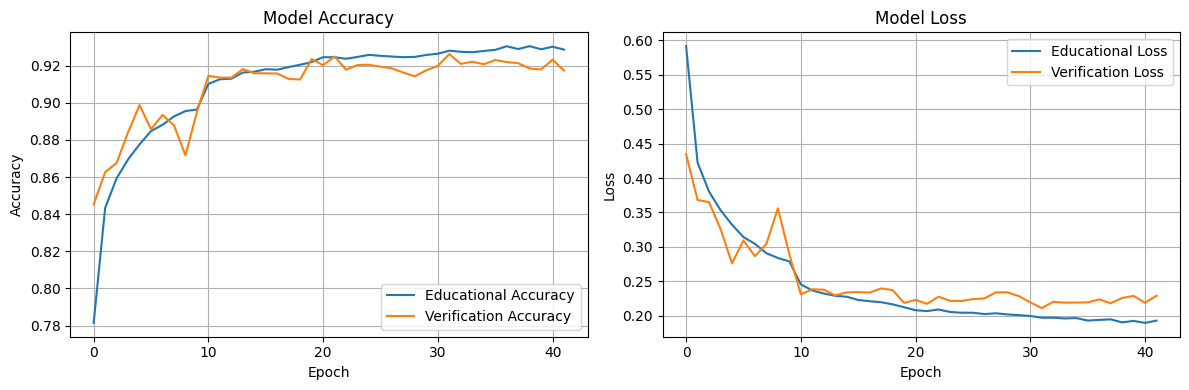

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Educational Accuracy')
plt.plot(history.history['val_accuracy'], label='Verification Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Educational Loss')
plt.plot(history.history['val_loss'], label='Verification Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

# **Modelin Test Performansının Değerlendirilmesi: Kayıp, Doğruluk, Sınıflandırma Raporu ve Görselleştirmeler**

Bu kod parçası, eğitilen CNN modelinin test verisi üzerindeki performansını detaylı olarak değerlendirmek için hazırlanmıştır. Öncelikle evaluate fonksiyonu ile test verisi üzerinde kayıp (loss) ve doğruluk (accuracy) hesaplanır ve ekrana yazdırılır. Ardından modelin tahminleri alınır (predict) ve her görüntü için en yüksek olasılığa sahip sınıf belirlenir. Gerçek sınıflarla karşılaştırılarak classification report üretilir; bu rapor, her sınıf için hassasiyet (precision), duyarlılık (recall) ve F1 skorlarını içerir. Ayrıca, tüm sınıflar için macro F1, macro precision ve macro recall değerleri hesaplanır.

Modelin hatalarını ve doğruluk dağılımını daha iyi görselleştirmek için confusion matrix (karışıklık matrisi) çizilir; bu matris, hangi sınıfların birbirine karıştığını net bir şekilde gösterir. Son olarak, test verisinde doğru ve yanlış sınıflandırılmış örnekler seçilerek ayrı görsellerde gösterilir. Üst kısımda doğru tahminler, alt kısımda ise yanlış tahminler yer alır; her görselin başlığında modelin tahmini ve gerçek sınıf etiketi belirtilir. Bu sayede modelin hangi durumlarda başarılı olduğu ve hangi sınıflarda hata yaptığı görsel olarak analiz edilebilir.

Test Loss: 0.2111
Test Accuracy: 0.9263
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.90      0.86      0.88      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.93      0.87      0.90      1000
       Dress       0.94      0.90      0.92      1000
        Coat       0.88      0.91      0.90      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.75      0.82      0.78      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.98      1.00      0.99      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Macro F1: 0.9267  | Macro Precision: 0.9278  | Macro Recall: 0.9263


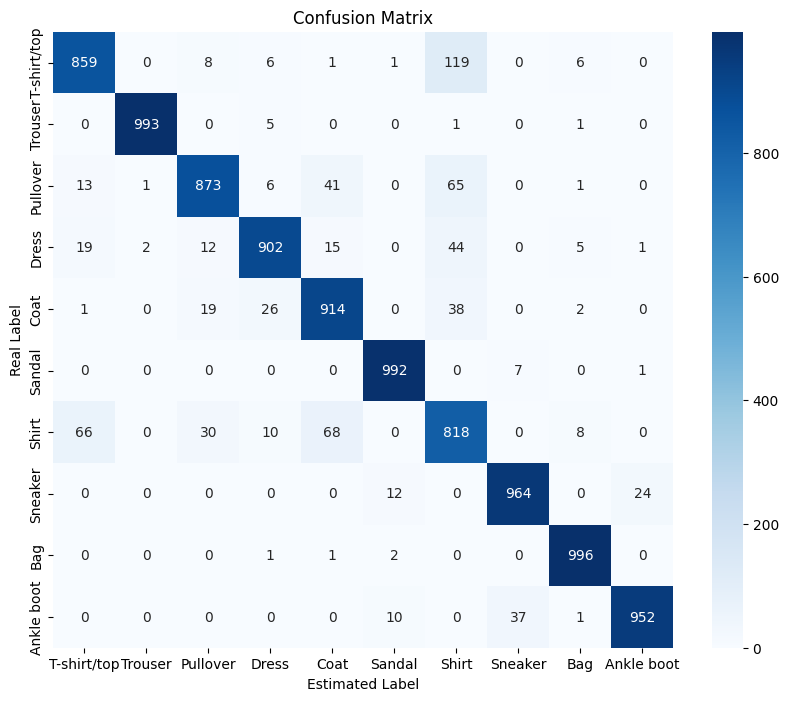

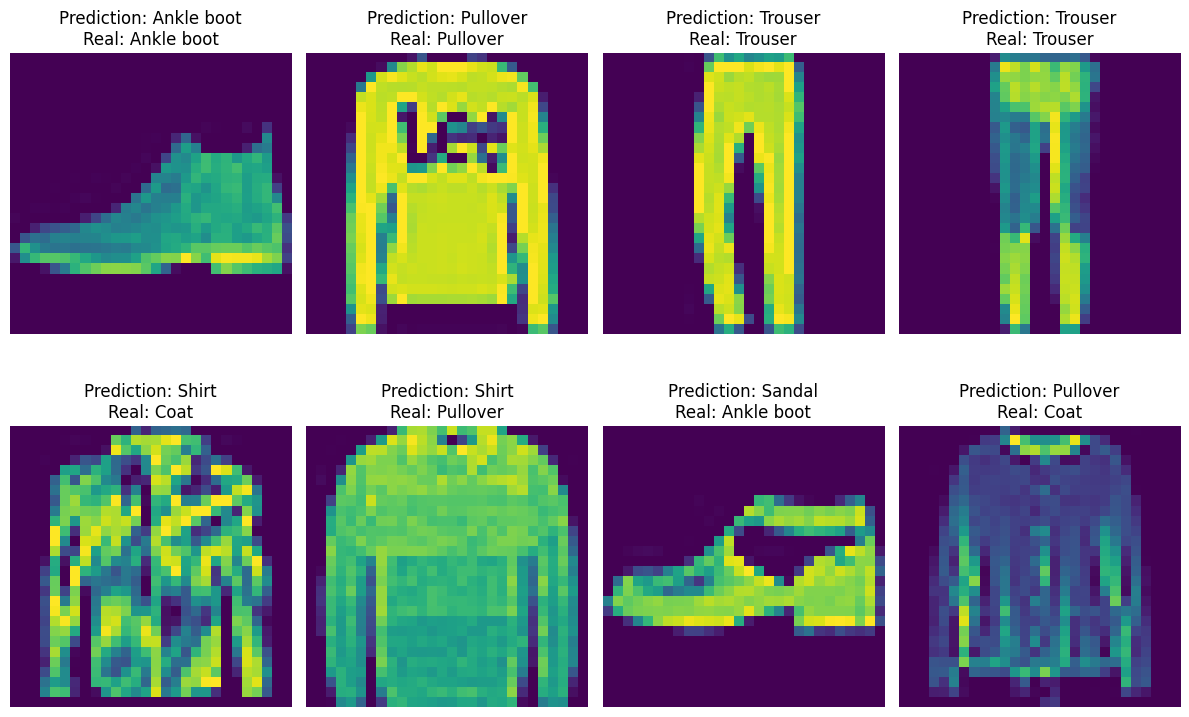

In [11]:
test_loss, test_accuracy = cnn_model.evaluate(testing_images , testing_categorical, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
prediction = cnn_model.predict(testing_images )
prediction_classes = np.argmax(prediction, axis=1)
true_classes = np.argmax(testing_categorical, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, prediction_classes, target_names=class_names))

macro_f1 = f1_score(true_classes, prediction_classes, average='macro')
macro_precision = precision_score(true_classes, prediction_classes, average='macro')
macro_recall = recall_score(true_classes, prediction_classes, average='macro')
print(f"Macro F1: {macro_f1:.4f}  | Macro Precision: {macro_precision:.4f}  | Macro Recall: {macro_recall:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_classes , prediction_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Real Label')
plt.xlabel('Estimated Label')
plt.show()

# Visualizing some examples of correct and incorrect predictions
correct_indices = np.where(prediction_classes == true_classes)[0]
incorrect_indices = np.where(prediction_classes != true_classes)[0]

plt.figure(figsize=(12, 8))

# Examples of correct predictions
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(testing_images[correct])
    plt.title(f"Prediction: {class_names[prediction_classes[correct]]}\nReal: {class_names[true_classes[correct]]}")
    plt.axis('off')

# Examples of incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    plt.imshow(testing_images[incorrect])
    plt.title(f"Prediction: {class_names[prediction_classes[incorrect]]}\nReal: {class_names[true_classes[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()